In [1]:
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, Dense, Activation, GaussianNoise, LeakyReLU, Dropout

In [2]:
feature = pd.read_csv('smote.csv')

In [3]:
features = feature.iloc[:,:-1]
target = feature.iloc[:,-1]

In [4]:
# Stop training model when "monitor parameter" has stopped improving
earlyStopping = EarlyStopping(monitor='loss', patience=50) # patience is num of epochs to reach early stopping
# Save model after every epoch
checkpointer = ModelCheckpoint(filepath='SDAE_Training.keras', verbose=1, save_best_only=True)
input_dims = (len(features)-1)

In [5]:
# Define denoising autoencoder function
def dae(inputX, input_dims, output_dims, epoch, activation, loss, opti):
    model = Sequential()

    # Check if input_dims is greater than 9999 to decide on CPU or GPU usage
    if input_dims > 9999:
        with tensorflow.device('/cpu:0'):
            print("Using CPU....")
            model.add(Dense(input_dims, input_dim=input_dims))
            model.add(GaussianNoise(0.5))
            model.add(Dense(output_dims, activation=activation, kernel_regularizer=regularizers.l1(0.01)))
            model.add(Dense(input_dims, activation=activation))
            model.compile(loss=loss, optimizer=opti)
            model.fit(inputX, inputX, epochs=epoch, batch_size=4)
            model.summary()
    else:
        with tensorflow.device('/device:GPU:0'):
            print("Using GPU....")
            model.add(Dense(input_dims, input_dim=input_dims))
            model.add(GaussianNoise(0.5))
            model.add(Dense(output_dims, activation=activation, kernel_regularizer=regularizers.l1(0.01)))
            model.add(Dense(input_dims, activation=activation))
            model.compile(loss=loss, optimizer=opti)
            model.fit(inputX, inputX, epochs=epoch, batch_size=4)
            model.summary()

    return model

In [6]:
# Call DAE function with features
autoencoder = dae(features,
                  input_dims=features.shape[1],  # Assuming all columns are used as input dimensions
                  output_dims=500,
                  epoch=3,
                  activation='relu',
                  loss='mse',
                  opti='adam'
                 )


Using CPU....

Epoch 1/3

332/332 [==============================] - 425s 1s/step - loss: 31.4600
Epoch 2/3
332/332 [==============================] - 420s 1s/step - loss: 7.8357
Epoch 3/3
332/332 [==============================] - 423s 1s/step - loss: 7.5829
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12000)             144012000 
                                                                 
 gaussian_noise (GaussianNo  (None, 12000)             0         
 ise)                                                            
                                                                 
 dense_1 (Dense)             (None, 500)               6000500   
                                                                 
 dense_2 (Dense)             (None, 12000)             6012000   
                                                           

In [7]:
# Hyper-parameter
layers = [12000, 8000, 4000, 500] # Setting the size of your layer
epoch = 3
optimizer = 'adam'
activation = 'relu'
loss = 'mse'

In [8]:
# SDAE pre-train
def sdae_pretrain (inputX, layers, activation, epoch, optimizer, loss):
        with tensorflow.device('/cpu:0'):
                encoder = []
                decoder = []
                ae = []

                for i in range(len(layers)-1):
                        print("Now pretraining layer {} [{}-->{}]".format(i+1, layers[i], layers[i+1]))

                        input_dims = layers[i]
                        output_dims = layers[i+1]

                        autoencoder = dae(inputX, input_dims, output_dims, epoch, activation, loss, optimizer)
                        enc = Sequential()
                        enc.add(Dense(output_dims, input_dim=input_dims))
                        enc.compile(loss=loss, optimizer=optimizer)
                        enc.layers[0].set_weights(autoencoder.layers[2].get_weights())
                        inputX = enc.predict(inputX)
                        print("check dimension : ", inputX.shape)
                        enc.summary()
                        encoder.append(autoencoder.layers[2].get_weights())
                        decoder.append(autoencoder.layers[3].get_weights())
                        ae.append(autoencoder)

                return ae

In [9]:
X = features
Y = target
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
Train_SDAE = sdae_pretrain( X, layers = layers, activation = activation, epoch = epoch, optimizer = optimizer, loss = loss)

Now pretraining layer 1 [12000-->8000]
Using CPU....
Epoch 1/3
332/332 [==============================] - 1025s 3s/step - loss: 420.3798
Epoch 2/3
332/332 [==============================] - 1019s 3s/step - loss: 254.3597
Epoch 3/3
332/332 [==============================] - 1017s 3s/step - loss: 559.2859
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12000)             144012000 
                                                                 
 gaussian_noise_1 (Gaussian  (None, 12000)             0         
 Noise)                                                          
                                                                 
 dense_4 (Dense)             (None, 8000)              96008000  
                                                                 
 dense_5 (Dense)             (None, 12000)             96012000  
             

In [11]:
for i, m in enumerate(Train_SDAE):
    filename="pretrain_model" + str(i) + ".keras"
    m.save(filename)

In [12]:
Train_SDAE = []
with tensorflow.device('/cpu:0'):
      Train_SDAE.append(load_model("pretrain_model0.keras"))
      Train_SDAE.append(load_model("pretrain_model1.keras"))
      Train_SDAE.append(load_model("pretrain_model2.keras"))

In [13]:
Train_SDAE

In [14]:
#Define confusion matrix
from tensorflow.keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision2 = precision(y_true, y_pred)
    recall2 = recall(y_true, y_pred)
    return 2*((precision2 * recall2)/(precision2 + recall2 + K.epsilon()))


In [16]:
# SDAE fine tuning
def fine_tuning(weights, inputX, inputXt, inputY, inputYt, layers, epoch, batch, optimizer, loss):

    inputX = inputX.astype('float32')
    inputXt = inputXt.astype('float32')
    inputY = inputY.astype('float32')
    inputYt = inputYt.astype('float32')
    
    encoder = []
    decoder = []

    for i in range(len(Train_SDAE)):

        encoder.append(Train_SDAE[i].layers[2].get_weights())
        decoder.append(Train_SDAE[i].layers[3].get_weights())

    with tensorflow.device('/device:gpu:0'): #I have to put this because the model size is too big for my GPU
        ft = Sequential()
        ft.add(Dense(layers[0], input_dim=layers[0]))
        ft.add(GaussianNoise(0.5))

        for i in range(len(layers)-1):
            ft.add(Dense(layers[i+1], activation = 'relu', kernel_regularizer = regularizers.l2(0.01))) # Initial regularizer (l1_l2)
            ft.layers[-1].set_weights(encoder[i])
            
        for i in reversed(range(len(layers)-1)):
            ft.add(Dense(layers[i], activation = 'relu'))
            ft.layers[-1].set_weights(decoder[i])
    ft.add(Dropout(0.2))
    ft.add(Dense(200, activation = 'relu'))
    ft.add(Dense(150, activation = 'relu', use_bias=True))
    ft.add(Dense(100, activation = 'relu', kernel_initializer= "glorot_uniform", bias_initializer= "zeros"))
    ft.add(Dense(50, activation= 'relu', kernel_initializer= "glorot_uniform", bias_initializer= "zeros"))
    ft.add(Dense(1, activation = 'sigmoid'))

    ft.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    inputY = inputY.astype('float32')
    inputYt = inputYt.astype('float32')
    
    History = ft.fit(X, Y, epochs = epoch, batch_size = batch, validation_data = (X_test, y_test))
    ft.summary()

    plt.plot(History.history['loss'])
    plt.plot(History.history['val_loss'])
    plt.title('SDAE Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

    plt.plot(History.history['accuracy'])
    plt.plot(History.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    return ft

Epoch 1/15
332/332 [==============================] - 1192s 4s/step - loss: nan - accuracy: 0.0657 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/15
332/332 [==============================] - 1192s 4s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/15
332/332 [==============================] - 1196s 4s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/15
332/332 [==============================] - 1200s 4s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/15
332/332 [==============================] - 1200s 4s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/15
332/332 [==============================] - 1200s 4s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/15
332/332 [==============================] - 1206s 4s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_acc

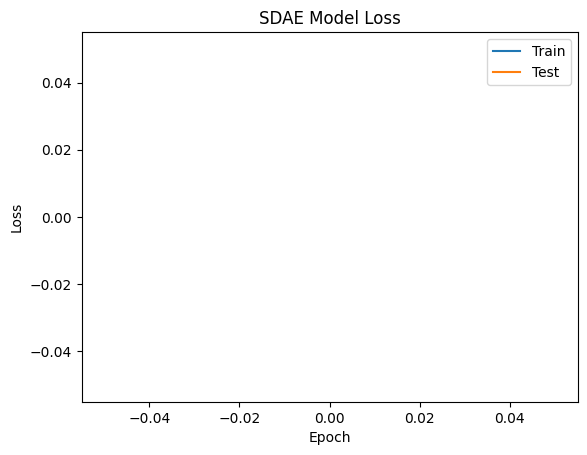

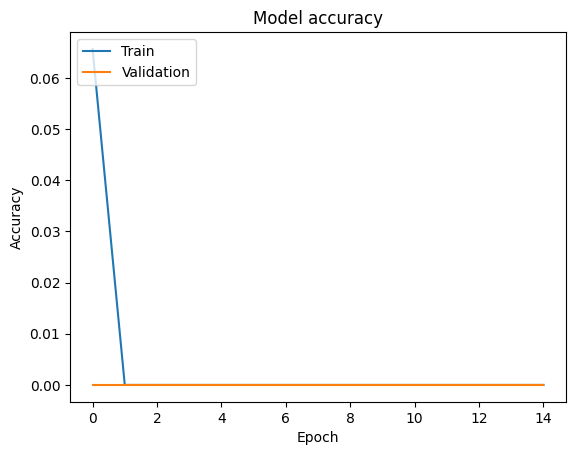

In [18]:
Result = fine_tuning(Train_SDAE, X, X_test, Y, y_test, layers = layers, epoch = 15, batch = 4, optimizer = 'adam', loss = 'binary_crossentropy')